# Ensembles

This example covers both ensembles and ensemble forecasts, which we call ensemble cycles ("cycles" since they could be analyses or forecasts).

## Ensemble Simulation

An ensemble simulation is a set of WRF-Hydro simulations. Indiviudal simulations are referred to as "members". Members start/restart at the same time and run for the same duration of time. However, all other properties of the members can vary including run-time options and files, and compile-time options. 

From `help(wrfhydropy.EnsembleSimulation)`:
```
Class for a WRF-Hydro EnsembleSimulation object. The Ensemble Simulation object is used to
orchestrate a set of 'N' WRF-Hydro simulations. It requires members with pre-compiled models
and there are set and get methods across the ensemble (member_diffs & set_member_diffs). Jobs
and scheduler set on the EnsembleSimulation object are set on all the members. 
```
This example builds from prior examples. Please refer to the earlier examples for more details on both Simulation and CycleSimulation objects.

## Preliminary

In [1]:
import copy
import datetime
import os
import pathlib
import pickle
from pprint import pprint
import subprocess
import sys
import wrfhydropy

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## User Configuration
This section should be all you need to tailor to your own machine.

In [2]:
model_repo = pathlib.Path('/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public')
experiment_dir = pathlib.Path('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example')
if not experiment_dir.exists():
    os.mkdir(str(experiment_dir))
os.chdir(str(experiment_dir))

## Simulation Object
First, we build the simulation that serves as the basis for the members of ensemble.  

The domain is pulled from the cloud, just as in the first (end-to-end) example. (Note that this section will not run on a cheyenne compute node as they are not connected to the internet.)

In [3]:
domain_dir = experiment_dir / 'domain'
if not domain_dir.exists(): 
    sys.path.append(str(model_repo / 'tests/local/utils'))
    from gdrive_download import download_file_from_google_drive
    file_id = '1xFYB--zm9f8bFHESzgP5X5i7sZryQzJe'
    file_target = 'gdrive_testcase.tar.gz'
    download_file_from_google_drive(
        file_id, 
        str(experiment_dir.joinpath(file_target)))
    untar_cmd = 'tar -xf ' + file_target + '; mv example_case domain'
    subprocess.run(
        untar_cmd, 
        shell=True,
        cwd=str(experiment_dir))

In [4]:
hrldas_model_side_file = model_repo / 'trunk/NDHMS/hrldas_namelists.json'
hrldas_domain_side_file = domain_dir / 'hrldas_namelist_patches.json'
hydro_model_side_file = model_repo / 'trunk/NDHMS/hydro_namelists.json'
hydro_domain_side_file = domain_dir / 'hydro_namelist_patches.json'
compile_options_file = model_repo / 'trunk/NDHMS/compile_options.json'
config = 'nwm_ana'

In [5]:
domain = wrfhydropy.Domain(
    domain_top_dir=domain_dir,
    domain_config=config)

In [6]:
model = wrfhydropy.Model(
    model_repo / 'trunk/NDHMS',
    compiler='ifort',
    compile_options={'WRF_HYDRO_NUDGING': 0},  # Turn off nudging for this ensemble experiment
    model_config=config)

In [7]:
compile_dir = experiment_dir / 'compile'
if not compile_dir.exists():
    model.compile(compile_dir)
else: 
    model = pickle.load(compile_dir.joinpath('WrfHydroModel.pkl').open('rb'))

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/wrfhydropy-0.0.18-py3.6.egg/wrfhydropy/core/model.py:193: UserWarning: /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/compile directory does not exist, creating
  warnings.warn(str(self.compile_dir.absolute()) + ' directory does not exist, creating')


Model successfully compiled into /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/compile


In [8]:
simulation = wrfhydropy.Simulation()
simulation.add(model)
simulation.add(domain)

Note that we dont need to compose or run the Simulation. 

## EnsembleSimulation Object
The documentation is always a work in progress! Please provide feedback on how to continue to improve it.

One can look at the documentation on the web  
https://wrfhydropy.readthedocs.io/en/latest/generated/wrfhydropy.EnsembleSimulation.html  
or one can ask for help within python:

In [9]:
help(wrfhydropy.EnsembleSimulation)

Help on class EnsembleSimulation in module wrfhydropy.core.ensemble:

class EnsembleSimulation(builtins.object)
 |  Class for a WRF-Hydro EnsembleSimulation object. The Ensemble Simulation object is used to
 |  orchestrate a set of 'N' WRF-Hydro simulations. It requires members with pre-compiled models
 |  and there are set and get methods across the ensemble (member_diffs & set_member_diffs). Jobs
 |  and scheduler set on the EnsembleSimulation object are set on all the members.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, ncores:int=1)
 |      Instantiates an EnsembleSimulation object.
 |  
 |  __len__(self)
 |  
 |  add(self, obj:Union[list, wrfhydropy.core.schedulers.Scheduler, wrfhydropy.core.job.Job])
 |      Add an approparite object to an EnsembleSimulation, such as a Simulation, Job, or
 |      Scheduler.
 |      Args:
 |          obj: the object to add.
 |  
 |  collect(self, output=True)
 |  
 |  compose(self, symlink_domain:bool=True, force:bool=False, check_nlst_

Instantiate the EnsembleSimulation, there are no required arguments.

In [10]:
ensemble = wrfhydropy.EnsembleSimulation()
ensemble.add(simulation)
ensemble.replicate_member(4)
len(ensemble)

4

In [11]:
pprint(ensemble.member_diffs)

{'number': ['000', '001', '002', '003'],
 'run_dir': ['member_000', 'member_001', 'member_002', 'member_003']}


We'll perturb 2 parameters to get four different members:  
  * dtrt_ch:  5, 20 minutes.   
  * Lakes: on, off 
  
First, `dtrt_ch` (the channel routing timestep) is set this way:

In [12]:
dtrtch_att_tuple = ('base_hydro_namelist', 'hydro_nlist', 'dtrt_ch')
ensemble.set_member_diffs(dtrtch_att_tuple, [5*60, 20*60, 5*60, 20*60])

The `dtrtch_att_tuple` is essentially a "path" into where `dtrt_ch` lives within the Simulation object. Exploring `simulation.__dict__` is how one understands these paths. The "path" described in the tuple can mix object attributes and dictionary keys. The `base_hydro_namelist` attribute of a simulation is where the namelists are assembled while they are living in memory, before they are written to disk. (The tag "base" was probably a bad choice because of the "base" namelists used in the JSON namelist files, which this is NOT.)

Turning off lakes requires setting two entries in the hydronamelist. These are changed in a similar way as above:

In [13]:
original_route_lake_f = simulation.base_hydro_namelist['hydro_nlist']['route_lake_f']
lakef_att_tuple = ('base_hydro_namelist', 'hydro_nlist', 'route_lake_f')
ensemble.set_member_diffs(lakef_att_tuple, [original_route_lake_f] * 2 + [''] * 2)
outlake_att_tuple = ('base_hydro_namelist', 'hydro_nlist', 'outlake')
ensemble.set_member_diffs(outlake_att_tuple, [1, 1, 0, 0])

Now let's verify the differences across the ensemble have changed to be something other than their names and places.

In [14]:
pprint(ensemble.member_diffs)

{'number': ['000', '001', '002', '003'],
 'run_dir': ['member_000', 'member_001', 'member_002', 'member_003'],
 ('base_hydro_namelist', 'hydro_nlist', 'dtrt_ch'): [300, 1200, 300, 1200],
 ('base_hydro_namelist', 'hydro_nlist', 'outlake'): [1, 1, 0, 0],
 ('base_hydro_namelist', 'hydro_nlist', 'route_lake_f'): ['./NWM/DOMAIN/LAKEPARM.nc',
                                                          './NWM/DOMAIN/LAKEPARM.nc',
                                                          '',
                                                          '']}


To run the ensemble, we'll need a Job. This job applies to all the members.

In [15]:
model_start_time = datetime.datetime(2011, 8, 26, 0)
model_end_time = model_start_time + datetime.timedelta(hours=24)
exe_cmd = 'mpirun -np 1 ./wrf_hydro.exe'
job_ensemble = wrfhydropy.Job(
    job_id='ensemble',
    exe_cmd=exe_cmd,
    model_start_time=model_start_time,
    model_end_time=model_end_time,
    restart=True,
    restart_freq_hr=6,
    output_freq_hr=1)

ensemble.add(job_ensemble)
ensemble_copy = copy.deepcopy(ensemble)

If we consider the ensemble "ready to go", we can compose it to disk. This compose step follows the same pattern as a Simulation or a CycleSimulation.

In [16]:
ensemble_dir = experiment_dir / 'ensemble'
os.mkdir(ensemble_dir)
os.chdir(ensemble_dir)
ensemble.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_000'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_002'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_003'
Getting domain files...
Making job directories...
Validating job input files
ens

As with Simulation objects, this time between compose (to disk) and run is a critical point for the user to look at the runs and verify that everything is configured correctly. 

These ensembles are independent of each other, so we choose to run them in parallel here, within the interactive run call.

In [17]:
ensemble.run(n_concurrent=4)

0

## Ensemble Collection
I have not yet implemented a syntactic sugar collection/open for more complicated objects than Simulations.... so we do this the "unchained" or "old fashioned" way. 

In [18]:
ens_chanobs_files = sorted(ensemble_dir.glob('*/*CHANOBS*'))
ens_chanobs_ds = wrfhydropy.open_whp_dataset(ens_chanobs_files)

n_files 96


Note that the `open_whp_dataset` function handles the dimension of the ensemble members.

In [19]:
ens_chanobs_ds

<xarray.Dataset>
Dimensions:     (feature_id: 4, member: 4, time: 24)
Coordinates:
    longitude   (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
    latitude    (feature_id) float32 41.470795 41.473614 41.449814 41.40192
  * time        (time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-08-27
  * feature_id  (feature_id) int32 6226948 6226964 6227008 6227150
  * member      (member) int64 0 1 2 3
Data variables:
    crs         (member, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    order       (member, time, feature_id) int32 3 2 4 4 3 2 4 ... 2 4 4 3 2 4 4
    elevation   (member, time, feature_id) float32 180.48 183.15 ... 147.61
    streamflow  (member, time, feature_id) float32 0.43056196 ... 1.0433522
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

Do the easiest plotting thing possible.

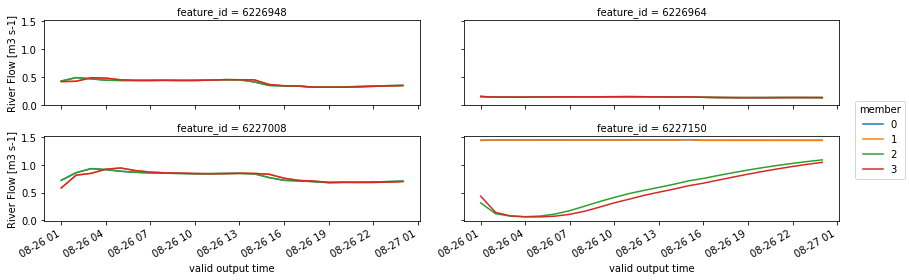

In [39]:
(ens_chanobs_ds.streamflow.plot
    .line(x='time', hue='member', col='feature_id',
          col_wrap=2,
          figsize=(12, 4)))

# Ensemble Cycles

The API gets a bit rough here but it is tested, there are a few decisions that just have not been fully made yet. Let me kow your thoughts on smoothing it out. 

Take a look at `help(wrfhydropy.CycleSimulaton)` or at https://wrfhydropy.readthedocs.io/en/latest/generated/wrfhydropy.CycleSimulation.html  
to see explaination of the form of the required arguments.

In [21]:
init_times = [datetime.datetime(2011, 8, 26, 0) + 
              datetime.timedelta(hours=hh) for hh in range(0, 24, 6)]
init_times

[datetime.datetime(2011, 8, 26, 0, 0),
 datetime.datetime(2011, 8, 26, 6, 0),
 datetime.datetime(2011, 8, 26, 12, 0),
 datetime.datetime(2011, 8, 26, 18, 0)]

For the restarts, take them from the original ensemble run. Unlike the CycleSimulation example, these casts and members will be "embarassingly parallel", casts do not depend on casts at a prior time. The restarts re already on disk, ready to go. This example can be thought of as an (non-cycling) ensemble analysis (EnsembleSimulation above) which provides restarts for launching ensemble forecasts.

In [22]:
restart_dirs_ens_cycle = [ [ensemble_dir / ('member_' + str(ii).zfill(3))] * 4 for ii in range(4)]
restart_dirs_ens_cycle

[[PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_000'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_000'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_000'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_000')],
 [PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001')],
 [PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_002'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_002'),
  PosixPath('/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_002'),
  PosixPath('/glade/scratch/ja

In [23]:
ens_cycle = wrfhydropy.CycleSimulation(
    init_times=init_times, restart_dirs=restart_dirs_ens_cycle)

In [24]:
ens_cycle.add(ensemble_copy)  # adding ensemble here will cause a type error because it was composed to disk
ens_cycle.add(job_ensemble)

In [25]:
ens_cycle_dir = experiment_dir / 'ens_cycle'
os.mkdir(ens_cycle_dir)
os.chdir(ens_cycle_dir)
ens_cycle.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082600/member_000'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082600/member_001'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082600/member_002'
Getting domain files...
Making job directories...
Validating job input files
ensemble
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082600/member_003'
Getting doma

As always, between `.compose()` and `.run()` is a critical moment to verify that the runs are setup correctly before consuming billions of core\*hours to execute them.  

Let's look at how the cycle ensemble is organized on disk and verify that it is setup correctly, at least a spot check or two. For each cast time, there is an ensemble:

In [26]:
%%bash
ls /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle

cast_2011082600
cast_2011082606
cast_2011082612
cast_2011082618


In [27]:
%%bash
ls /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082606

member_000
member_001
member_002
member_003
WrfHydroEns.pkl


And we check that the restarts are coming from the original ensemble run, and from the right member at the right time.

In [28]:
%%bash
cd /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082606/member_000; grep restart_f job*/*namelist*

job_ensemble/hydro.namelist:    restart_file = '/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001/HYDRO_RST.2011-08-26_06:00_DOMAIN1'
job_ensemble/namelist.hrldas:    restart_filename_requested = '/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001/RESTART.2011082606_DOMAIN1'
job_ensemble/namelist.hrldas:    restart_frequency_hours = 6


In [29]:
%%bash
cd /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cast_2011082606/member_002; grep restart_f job*/*namelist*

job_ensemble/hydro.namelist:    restart_file = '/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001/HYDRO_RST.2011-08-26_06:00_DOMAIN1'
job_ensemble/namelist.hrldas:    restart_filename_requested = '/glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ensemble/member_001/RESTART.2011082606_DOMAIN1'
job_ensemble/namelist.hrldas:    restart_frequency_hours = 6


## Teams run

Teams run minimizes the use of a scheduler (PBS/SLURM) as much as possible by managing many calls to MPI (WRF-Hydro executions) from the submitted job script. The "teams" are groups of processors over multiple compute nodes which each process some set of WRF-Hydro simulations in serial, the multiple teams working in parallel. In the example below: each WRF-Hydro simulation uses 1 core, there are 16 total simulations, and the resources are 2 nodes and 8 cores per node. All the simulations will be run in parallel.

Teams mode was originally developed for short or small jobs (and job arrays) which were single execuations of WRF-Hydro where the wait time in the queue approximated (or exceeded) the execution time of the model/job. Instead of submitting many "small" jobs (arrays) to the queue, one big job is submitted and many individual simulations are managed within a single job by wrfhydropy. 

As you might guess, the success of this approach and its syntax are highly dependent on the MPI flavor employed. Intel fortran has been the most used, though OpenMPI has been used as well. Every attempt has been made to separate out the MPI syntax into arguments. 

It is also note worthy that Teams have only been applied when the number of cores to be used for a single simulation are contained on a single compute node. Though not currently implemented, we have a strategy for also handling larger (multi-node) simulations using this approach. The success of this depends very much on MPI flavor. 

Teams mode in the master branch is for PBS but a SLURM implementation exists in a branch (pending merging when tests are developed for both).

As for using it, the recipe is as follows. When `.run()` is scheduled (e.g. in the end-to-end example), the method pickles the object to run before running it and this is hidden from the user. In the case of a teams run, we have to do this manually (currently, this is one place the API could be improved).

In [30]:
ens_cycle.pickle(ens_cycle_dir / 'WrfHydroCycle.pkl')

Next the a run script is to be placed in the `ens_cycle_dir` directory. The following template has not yet been added to the repo, mostly because there are often so many customizations for PBS and SLURM that there's some uncertainty about the best appraoch to including it. The prevailing, unimplemented idea is to make the following string variable, `submit_script`, available to import. This would provide a starting point which the user could edit and define/remove variables.

In [31]:
submit_script = (
"""#!/usr/bin/env python
#PBS -N {job_name}
#PBS -A {account}
#PBS -q {queue}
#PBS -M {email_who}
#PBS -m {email_when}
#PBS -l walltime={walltime}
{afterok}

#PBS -l select={n_nodes}:ncpus={n_proc_node}:mpiprocs={n_proc_node}

# Not using PBS standard error and out files to capture model output
# but these files might catch output and errors from the scheduler.
#PBS -o {job_name}.stdout
#PBS -e {job_name}.stderr

import wrfhydropy
import pickle
import os
import pathlib
import sys

job_dir = "{job_dir}"
print('job_dir: ', str(job_dir))
os.chdir(str(job_dir))

ens = pickle.load(open('WrfHydroCycle.pkl', mode='rb'))
ret_val = ens.run(
    teams=True,
    teams_exe_cmd_nproc={n_proc_exe},
    teams_exe_cmd="{mpi_cmd}")

sys.exit(ret_val)
""")

We format the variables in the above string by passing a dictionary and we write that formatted string to file. 

In [32]:
sched_params = {
    'job_name': 'cyteamex', 
    'account': 'NRAL0017',
    'queue': 'regular',
    'email_who': 'jamesmcc' + '@' + 'ucar' + '.' + 'edu',
    'email_when': 'abe',
    'walltime': '00:15:00',
    'afterok': '',
    'n_nodes': 2,
    'n_proc_node': 8,
    'n_proc_exe': 1,
    'job_dir': str(ens_cycle_dir),
    'mpi_cmd': exe_cmd,
}
submit_script_fmt = submit_script.format(**sched_params)
with (ens_cycle_dir / 'run_cycle.py').open('w') as file:    
    file.write(submit_script_fmt) 

Then we submit the script to the scheduler... 

In [33]:
%%bash
qsub run_cycle.py

1596391.chadmin1.ib0.cheyenne.ucar.edu


How do we know the cycle ensemble finished successfully? One way is to look at the standard error and standard out files for the job.

In [34]:
%%bash
cat /glade/scratch/jamesmcc/wrfhydropy_ensemble_example/ens_cycle/cyteamex.stderr

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


But there are other simple programmatic tests one can do (relying on the .model_end_time file mechanism of wrfhydropy):

In [35]:
n_ens_casts = len(sorted(ens_cycle_dir.glob('cast*/member*')))
n_complete_casts = len(sorted(ens_cycle_dir.glob('cast*/member*/.model_end_time')))
print(str(n_ens_casts) + ' ?=? ' + str(n_complete_casts))
assert n_ens_casts is n_complete_casts

16 ?=? 16


## Collect Cycle Ensemble
Once again, `wrfhydropy.open_whp_dataset` handles the dimensions of this run natively. 

In [36]:
ens_cycle_chanobs_files = sorted(ens_cycle_dir.glob('**/*CHANOBS*'))
ens_cycle_chanobs_ds = wrfhydropy.open_whp_dataset(ens_cycle_chanobs_files)

n_files 384


In [37]:
ens_cycle_chanobs_ds

<xarray.Dataset>
Dimensions:         (feature_id: 4, lead_time: 24, member: 4, reference_time: 4)
Coordinates:
    longitude       (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
    latitude        (feature_id) float32 41.470795 41.473614 41.449814 41.40192
  * member          (member) int64 0 1 2 3
  * feature_id      (feature_id) int32 6226948 6226964 6227008 6227150
  * reference_time  (reference_time) datetime64[ns] 2011-08-26 ... 2011-08-26T18:00:00
  * lead_time       (lead_time) timedelta64[ns] 01:00:00 ... 1 days 00:00:00
Data variables:
    crs             (lead_time, member, reference_time) |S1 b'' b'' ... b'' b''
    order           (lead_time, member, reference_time, feature_id) int32 3 ... 4
    elevation       (lead_time, member, reference_time, feature_id) float32 180.48 ... 147.61
    streamflow      (lead_time, member, reference_time, feature_id) float32 0.43056196 ... 1.3508004
    valid_time      (lead_time, reference_time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-08-27T18:00:00
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

In this case we'll just plot for feature_id 6227150.

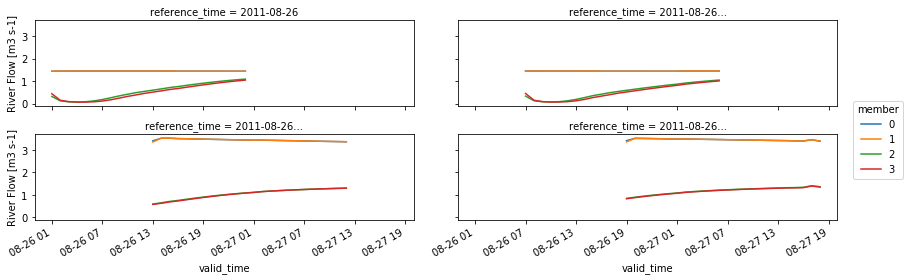

In [38]:
ens_cycle_chanobs_ds = ens_cycle_chanobs_ds.set_coords('valid_time')
(
    ens_cycle_chanobs_ds
    .streamflow
    .sel(feature_id=6227150)
    .plot
    .line(
        x='valid_time', col='reference_time', hue='member', 
        col_wrap=2,
        figsize=(12, 4)))